# Great Learning Hackathon

- The goal of the use case is to perform prediction whether a passenger is satisfied or not with his/her travel experience in the Shinkansen Bullet Train. The field to predict is Overall_Experience from the Surveydata collected.

- This use case is a Classification problem with binary Target class (**Overall_Experience = 0: Unsatisfied, 1: Satisfied**). There are 2 sets of input data: The **Survey data & the train Travel data**.

- The project implements the standard Data Mining practice e.g. Data Exploration, Data Processing, handling of missing values, Data Preparation for Modeling, and tests out a few Machine Learning algorithms in order to obtain the best model with the best accuracy to predict Customers Satisfaction.

- The best model achieved is the Random Forest model at 95.2% accuracy

# 1. Import packages

In [1]:
import pandas as pd              # data manipulation
import numpy as np               # math operations on arrays / random number gen
import matplotlib.pyplot as plt  # visualization package
import seaborn as sns            # visualization package
from math import ceil, floor     # math rounding operations
from numpy import mean
from numpy import std

# Import Feature Scaler
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Metrics to evaluate the model
# from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve,recall_score

# For tuning the model
from sklearn.model_selection import GridSearchCV

### KNN Imputation with Different No. of Neighbors
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score


# 2. Read training data

In [2]:
survey_data = pd.read_csv('Surveydata_train.csv')
travel_data = pd.read_csv('Traveldata_train.csv')

In [3]:
survey_data.Overall_Experience.value_counts()

1    51593
0    42786
Name: Overall_Experience, dtype: int64

In [4]:
survey_data.Overall_Experience.value_counts(normalize=True)

1    0.546658
0    0.453342
Name: Overall_Experience, dtype: float64

# 3. Functions for EDA

In [5]:
# ------------------------
# INITIALIZE PLOT SETTING
#-------------------------
# Defining function to set figure size
def figure(a,b):
    sns.set(rc={'figure.figsize':(a,b)})

In [6]:
# Function to plot count plots on categorical data
# Input: DF, Required No. of columns in Subplot
def plot_cats(df, plt_cols): 
    
    df_string = df.loc[:,df.dtypes == 'object']
    df_string['Overall_Experience'] = df['Overall_Experience']
    cols = df_string.columns
    
    df0 = df_string[df_string.Overall_Experience == 0]
    df1 = df_string[df_string.Overall_Experience == 1]
    
    plt_rows = ceil(len(cols)/plt_cols)

    fig1, axes = plt.subplots(plt_rows,plt_cols)
    axes = axes.ravel()

    figure(15,30)
    i = 0
    for col in cols:

        sns.countplot(df_string[col], hue=df_string.Overall_Experience, ax=axes[i], palette = ['lightcoral','limegreen'])  
        axes[i].set_title('Countplot of ' + col, size=12)
        axes[i].tick_params(axis='x', labelrotation=70)
    
        fig1.tight_layout(rect=[0, 0, 1, 0.88])
        i = i+1
    
    fig1.legend(["0: Bad experience", "1: Good experience"], loc ="right", bbox_to_anchor=(1.15,0.5))


In [7]:
# ---------------------
# NUMERICAL VARIABLES
# ---------------------
# Function to plot distribution plots on categorical data
# Input: DF, Required No. of columns in Subplot
def plot_nums(df, plt_cols): 
    
    df_numeric0 = df.loc[:, df.dtypes!='object']

    # Check presence of Index / index 
    #  and drop those columns
    id_cols = ['Index', 'index']
    df_numeric = df_numeric0.loc[:, ~df_numeric0.columns.isin(id_cols)]
    df_numeric['Overall_Experience'] = df['Overall_Experience']
    cols = df_numeric.columns

    df0 = df_numeric[df_numeric.Overall_Experience == 0]
    df1 = df_numeric[df_numeric.Overall_Experience == 1]

    plt_rows = ceil(len(df_numeric.columns)/plt_cols)             # Set the no. of rows in subplot by dividing: 
                                                                  #  roundup(no. of variables / no. of columns)
    fig2, axes = plt.subplots(plt_rows,plt_cols)
    fig2.suptitle("Distribution Plots of Numerical Variables \n (x-axis: Variable) \n (y-axis: Distribution proportion)", 
                 fontsize="x-large")
    axes = axes.ravel()


    for i in range(0, len(df_numeric.columns)):
        sns.distplot(df0.iloc[:,i], ax=axes[i], color='red')            # Plot countplot for each categorical variable
        sns.distplot(df1.iloc[:,i], ax=axes[i], color='limegreen')      # Plot countplot for each categorical variable
        axes[i].set_title(df_numeric.columns[i], size=15)         # Set title of every subplot
        axes[i].tick_params(axis='x', labelrotation=90, pad=0)    # Rotate x-axis of every subplot
        axes[i].set_xlabel('')                                    # Turn off subplots' x-axis titles for tidiness
    fig2.legend(["0: Bad experience", "1: Good experience"], loc ="right", bbox_to_anchor=(1.15,0.5))
    fig2.tight_layout(rect=[0, 0, 1, 0.88])                       # Adjust tight_layout to accommodate suptitle

# 4. Feature Engineering

## 4.1. Merge Data

In [8]:
survey_data.head(3)

,ID,Overall_Experience,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,98800001,0,Needs Improvement,Green Car,Excellent,Excellent,Very Convenient,Good,Needs Improvement,Acceptable,Needs Improvement,Needs Improvement,Acceptable,Needs Improvement,Good,Needs Improvement,Poor
1,98800002,0,Poor,Ordinary,Excellent,Poor,Needs Improvement,Good,Poor,Good,Good,Excellent,Needs Improvement,Poor,Needs Improvement,Good,Good
2,98800003,1,Needs Improvement,Green Car,Needs Improvement,Needs Improvement,Needs Improvement,Needs Improvement,Good,Excellent,Excellent,Excellent,Excellent,Excellent,Good,Excellent,Excellent


In [9]:
travel_data.head(3)

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
0,98800001,Female,Loyal Customer,52.0,NaN,Business,272,0.0,5.0
1,98800002,Male,Loyal Customer,48.0,Personal Travel,Eco,2200,9.0,0.0
2,98800003,Female,Loyal Customer,43.0,Business Travel,Business,1061,77.0,119.0


In [10]:
print('survey_data shape: ', survey_data.shape)
print('travel_data shape: ', travel_data.shape)

survey_data shape:  (94379, 17)
travel_data shape:  (94379, 9)


In [11]:
# df = pd.concat([survey_data, travel_data], axis=1, join='left')
def merge_data(survey_data, travel_data):
    df = survey_data.merge(travel_data, how='left', on=('ID'))
    return(df)

df = merge_data(survey_data, travel_data)
print('df shape: ', df.shape)
df.head()

df shape:  (94379, 25)


,ID,Overall_Experience,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,...,Cleanliness,Online_Boarding,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
0,98800001,0,Needs Improvement,Green Car,Excellent,Excellent,Very Convenient,Good,Needs Improvement,Acceptable,...,Needs Improvement,Poor,Female,Loyal Customer,52.0,NaN,Business,272,0.0,5.0
1,98800002,0,Poor,Ordinary,Excellent,Poor,Needs Improvement,Good,Poor,Good,...,Good,Good,Male,Loyal Customer,48.0,Personal Travel,Eco,2200,9.0,0.0
2,98800003,1,Needs Improvement,Green Car,Needs Improvement,Needs Improvement,Needs Improvement,Needs Improvement,Good,Excellent,...,Excellent,Excellent,Female,Loyal Customer,43.0,Business Travel,Business,1061,77.0,119.0
3,98800004,0,Acceptable,Ordinary,Needs Improvement,NaN,Needs Improvement,Acceptable,Needs Improvement,Acceptable,...,Acceptable,Acceptable,Female,Loyal Customer,44.0,Business Travel,Business,780,13.0,18.0
4,98800005,1,Acceptable,Ordinary,Acceptable,Acceptable,Manageable,Needs Improvement,Good,Excellent,...,Good,Good,Female,Loyal Customer,50.0,Business Travel,Business,1981,0.0,0.0


## 4.2. Oversampling / Undersampling

In [12]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler 

In [13]:
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

# 1-(0.55/0.45)
# define undersample strategy
# undersample = RandomUnderSampler(sampling_strategy=0.5)

In [14]:
X = df.drop(['ID','Overall_Experience'], axis=1)
y = df[['Overall_Experience']]
# fit and apply the transform
X_over, y_over = undersample.fit_resample(X, y)

In [15]:
y_over.Overall_Experience.value_counts()

0    42786
1    42786
Name: Overall_Experience, dtype: int64

In [16]:
X_over.shape

(85572, 23)

In [17]:
X_over.tail()

,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,...,Cleanliness,Online_Boarding,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
85567,Good,Green Car,Acceptable,Acceptable,Manageable,Needs Improvement,Good,Good,Excellent,Excellent,...,Excellent,Good,Female,Loyal Customer,34.0,Personal Travel,Eco,1838,7.0,6.0
85568,Excellent,Green Car,Excellent,Excellent,Very Convenient,Excellent,Excellent,Excellent,Excellent,Acceptable,...,Acceptable,Excellent,Male,Loyal Customer,50.0,Business Travel,Eco,2566,0.0,21.0
85569,Poor,Green Car,Poor,Poor,Inconvenient,Excellent,Good,Good,Good,Good,...,Good,Excellent,Male,Loyal Customer,46.0,Business Travel,Business,92,0.0,11.0
85570,Poor,Ordinary,Poor,Poor,Inconvenient,Excellent,Good,Excellent,Excellent,Excellent,...,Excellent,Excellent,Female,Loyal Customer,61.0,NaN,Business,3925,0.0,1.0
85571,Good,Green Car,NaN,Good,Convenient,Excellent,Acceptable,Excellent,Good,Good,...,Good,Good,Female,Loyal Customer,44.0,Personal Travel,Eco,489,0.0,0.0


In [18]:
y_over.shape
y_over.tail()

,Overall_Experience
85567,1
85568,1
85569,1
85570,1
85571,1


In [19]:
X_over = X_over.reset_index(drop=True)
y_over = y_over.reset_index(drop=True)

df2 = pd.concat([X_over, y_over], axis=1)
df2.shape

(85572, 24)

In [20]:
df2.tail()

,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,...,Online_Boarding,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Overall_Experience
85567,Good,Green Car,Acceptable,Acceptable,Manageable,Needs Improvement,Good,Good,Excellent,Excellent,...,Good,Female,Loyal Customer,34.0,Personal Travel,Eco,1838,7.0,6.0,1
85568,Excellent,Green Car,Excellent,Excellent,Very Convenient,Excellent,Excellent,Excellent,Excellent,Acceptable,...,Excellent,Male,Loyal Customer,50.0,Business Travel,Eco,2566,0.0,21.0,1
85569,Poor,Green Car,Poor,Poor,Inconvenient,Excellent,Good,Good,Good,Good,...,Excellent,Male,Loyal Customer,46.0,Business Travel,Business,92,0.0,11.0,1
85570,Poor,Ordinary,Poor,Poor,Inconvenient,Excellent,Good,Excellent,Excellent,Excellent,...,Excellent,Female,Loyal Customer,61.0,NaN,Business,3925,0.0,1.0,1
85571,Good,Green Car,NaN,Good,Convenient,Excellent,Acceptable,Excellent,Good,Good,...,Good,Female,Loyal Customer,44.0,Personal Travel,Eco,489,0.0,0.0,1


## 4.3. Feature Encoding

In [21]:
# df2 = df.copy() 
df2.head()

,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,...,Online_Boarding,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Overall_Experience
0,Needs Improvement,Green Car,Excellent,Excellent,Very Convenient,Good,Needs Improvement,Acceptable,Needs Improvement,Needs Improvement,...,Poor,Female,Loyal Customer,52.0,NaN,Business,272,0.0,5.0,0
1,Poor,Ordinary,Excellent,Poor,Needs Improvement,Good,Poor,Good,Good,Excellent,...,Good,Male,Loyal Customer,48.0,Personal Travel,Eco,2200,9.0,0.0,0
2,Acceptable,Ordinary,Needs Improvement,NaN,Needs Improvement,Acceptable,Needs Improvement,Acceptable,Acceptable,Acceptable,...,Acceptable,Female,Loyal Customer,44.0,Business Travel,Business,780,13.0,18.0,0
3,Good,Green Car,Excellent,Good,Inconvenient,Good,Good,Good,Good,Good,...,Good,Male,Loyal Customer,56.0,Personal Travel,Eco,2029,0.0,0.0,0
4,Acceptable,Green Car,NaN,Acceptable,Inconvenient,Excellent,Excellent,Good,Good,Good,...,Excellent,Male,Loyal Customer,65.0,Personal Travel,Business,853,0.0,3.0,0


In [22]:
def encode_data(df):
    # All except Platform_Location
    dict1 = {'Extremely Poor'  : 0,
            'Poor'             : 1,
            'Needs Improvement': 2,
            'Acceptable'       : 3,
            'Good'             : 4,
            'Excellent'        : 5}
    
    # Platform_Location
    dict2 = {'Very Inconvenient': 0,
            'Inconvenient'      : 1,
            'Needs Improvement' : 2,
            'Manageable'        : 3,
            'Convenient'        : 4,
            'Very Convenient'   : 5}
    
    # Cols to remove are columns with binary classes
    # Their classes are not standard e.g. Gender: Male, Female
    # Thus, they will be managed by one-hot encoding
    cols_to_remove = ['Seat_Class','Gender', 'Customer_Type', 'Type_Travel','Travel_Class',
                     'Platform_Location']
    # cols_to_remove = []
    cols_encode = df.columns[df.dtypes =='object']
    cols_encode = cols_encode[~cols_encode.isin(cols_to_remove)]
    
    df_encode = df[cols_encode]

    # Replace value by the numeric values in dict1
    for col in cols_encode:
        df_encode = df_encode.replace({col: dict1})

    # Replace values in Platform_Location by dict2
    df_encode['Platform_Location'] = df[['Platform_Location']].replace({'Platform_Location': dict2})
    df_encode['Seat_Class']        = df['Seat_Class'].map({'Green Car':0, 'Ordinary':1 })
    df_encode['Gender']            = df['Gender'].map({'Male':0, 'Female':1 })
    df_encode['Customer_Type']     = df['Customer_Type'].map({'Disloyal Customer':0, 'Loyal Customer':1 })
    df_encode['Type_Travel']       = df['Type_Travel'].map({'Personal Travel':0, 'Business Travel':1 })
    df_encode['Travel_Class']      = df['Travel_Class'].map({'Eco':0, 'Business':1 })
    
    return(df_encode)
    # Output: df_encode

In [23]:
df_encode = encode_data(df2)
print(df_encode.shape)
df_encode.columns

(85572, 19)


Index(['Seat_Comfort', 'Arrival_Time_Convenient', 'Catering',
       'Onboard_Wifi_Service', 'Onboard_Entertainment', 'Online_Support',
       'Ease_of_Online_Booking', 'Onboard_Service', 'Legroom',
       'Baggage_Handling', 'CheckIn_Service', 'Cleanliness', 'Online_Boarding',
       'Platform_Location', 'Seat_Class', 'Gender', 'Customer_Type',
       'Type_Travel', 'Travel_Class'],
      dtype='object')

## 4.4. Merge encoded DFs

In [24]:
## No encoding (numeric variables)
# Numeric variables:
def merged_encoded_data(df_encode, df2):
    cols_num = ['Age', 'Travel_Distance', 'Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins']
    # df3 = pd.concat([df_encode, df2], axis=1)
    df3 = pd.concat([df2[cols_num], df_encode], axis=1)
    return(df3)

In [25]:
# pd.set_option("display.max_columns", None)

In [26]:
df3 = merged_encoded_data(df_encode, df2)
print(df3.shape)
df3.head()

(85572, 23)


,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Seat_Comfort,Arrival_Time_Convenient,Catering,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,...,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding,Platform_Location,Seat_Class,Gender,Customer_Type,Type_Travel,Travel_Class
0,52.0,272,0.0,5.0,2.0,5.0,5.0,4.0,2.0,3.0,...,2.0,4.0,2.0,1.0,5.0,0,1.0,1.0,NaN,1
1,48.0,2200,9.0,0.0,1.0,5.0,1.0,4.0,1.0,4.0,...,1.0,2.0,4.0,4.0,2.0,1,0.0,1.0,0.0,0
2,44.0,780,13.0,18.0,3.0,2.0,NaN,3.0,2.0,3.0,...,3.0,4.0,3.0,3.0,2.0,1,1.0,1.0,1.0,1
3,56.0,2029,0.0,0.0,4.0,5.0,4.0,4.0,4.0,4.0,...,2.0,5.0,3.0,4.0,1.0,0,0.0,1.0,0.0,0
4,65.0,853,0.0,3.0,3.0,NaN,3.0,5.0,5.0,4.0,...,4.0,4.0,4.0,5.0,1.0,0,0.0,1.0,0.0,1


# 5. Handle Missing data by KNN imputing

In [27]:
df4 = df3.copy()
df4.head()

,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Seat_Comfort,Arrival_Time_Convenient,Catering,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,...,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding,Platform_Location,Seat_Class,Gender,Customer_Type,Type_Travel,Travel_Class
0,52.0,272,0.0,5.0,2.0,5.0,5.0,4.0,2.0,3.0,...,2.0,4.0,2.0,1.0,5.0,0,1.0,1.0,NaN,1
1,48.0,2200,9.0,0.0,1.0,5.0,1.0,4.0,1.0,4.0,...,1.0,2.0,4.0,4.0,2.0,1,0.0,1.0,0.0,0
2,44.0,780,13.0,18.0,3.0,2.0,NaN,3.0,2.0,3.0,...,3.0,4.0,3.0,3.0,2.0,1,1.0,1.0,1.0,1
3,56.0,2029,0.0,0.0,4.0,5.0,4.0,4.0,4.0,4.0,...,2.0,5.0,3.0,4.0,1.0,0,0.0,1.0,0.0,0
4,65.0,853,0.0,3.0,3.0,NaN,3.0,5.0,5.0,4.0,...,4.0,4.0,4.0,5.0,1.0,0,0.0,1.0,0.0,1


In [28]:
print(df4.isna().sum())

Age                          28
Travel_Distance               0
Departure_Delay_in_Mins      52
Arrival_Delay_in_Mins       321
Seat_Comfort                 57
Arrival_Time_Convenient    8091
Catering                   7930
Onboard_Wifi_Service         27
Onboard_Entertainment        16
Online_Support               81
Ease_of_Online_Booking       65
Onboard_Service            6866
Legroom                      81
Baggage_Handling            129
CheckIn_Service              69
Cleanliness                   4
Online_Boarding               4
Platform_Location            27
Seat_Class                    0
Gender                       70
Customer_Type              8107
Type_Travel                8373
Travel_Class                  0
dtype: int64


In [29]:
STOP

NameError: name 'STOP' is not defined

In [30]:
# def split_imputation(df5):
#     cols = df5.columns[~df5.columns.isin(['Overall_Experience'])].tolist()
#     cols.append('Overall_Experience')
#     # cols

#     # Rearrange columns with 'Overall_Experience' placed at the end of the df
#     df5 = df5[cols]

#     # split into input and output elements
#     X, y = df5.iloc[:, :-1], df5.iloc[:, -1:]

#     return(X, y)

In [31]:
# n_neighbors = 4
def knn_imputer_fitting(X, n_neighbors):
    # define imputer
    # imputer = Onboard_Wifi_Service(n_neighbors = 1)
    imputer = KNNImputer(n_neighbors = n_neighbors)
    # fit on the dataset
    imputer.fit(X)
    return(imputer)

In [32]:
def knn_impute(X, imputer):
    # transform the dataset
    Xtrans = imputer.transform(X)
    df4 = pd.DataFrame(Xtrans, columns=X.columns)
    return(df4)

In [33]:
imputer    = knn_imputer_fitting(df4, 3)
df5        = knn_impute(df4, imputer)

In [34]:
df5.isna().sum()

Age                        0
Travel_Distance            0
Departure_Delay_in_Mins    0
Arrival_Delay_in_Mins      0
Seat_Comfort               0
Arrival_Time_Convenient    0
Catering                   0
Onboard_Wifi_Service       0
Onboard_Entertainment      0
Online_Support             0
Ease_of_Online_Booking     0
Onboard_Service            0
Legroom                    0
Baggage_Handling           0
CheckIn_Service            0
Cleanliness                0
Online_Boarding            0
Platform_Location          0
Seat_Class                 0
Gender                     0
Customer_Type              0
Type_Travel                0
Travel_Class               0
dtype: int64

# 6. Feature Scaling

In [35]:
def standardscaler(df_fe):
    # define standard scaler
    scaler = StandardScaler()
    # transform data
    scaled = scaler.fit_transform(df_fe)
    df6 = pd.DataFrame(scaled, columns=df_fe.columns)
    return(df6)

In [36]:
def minmaxscaler(df_fe):
    # define min max scaler
    scaler = MinMaxScaler()
    # transform data
    scaled = scaler.fit_transform(df_fe)
    df6 = pd.DataFrame(scaled, columns=df_fe.columns)
    return(df6)

In [38]:
# df4 = minmaxscaler(df3)
df6 = standardscaler(df5)
df6 = pd.concat([df6, df2[['Overall_Experience']]], axis=1)

In [39]:
df6.head()

,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Seat_Comfort,Arrival_Time_Convenient,Catering,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,...,CheckIn_Service,Cleanliness,Online_Boarding,Platform_Location,Seat_Class,Gender,Customer_Type,Type_Travel,Travel_Class,Overall_Experience
0,0.838836,-1.680551,-0.386864,-0.265233,-0.591174,1.351766,1.552155,0.588010,-0.976770,-0.357278,...,0.544303,-1.450975,-1.766471,1.541021,-0.994592,1.005375,0.503156,-1.515322,1.078671,0
1,0.575721,0.215694,-0.152785,-0.393809,-1.321531,1.351766,-1.327917,0.588010,-1.720114,0.402589,...,-1.036037,0.281183,0.527419,-0.764001,1.005437,-0.995119,0.503156,-1.515322,-0.927067,0
2,0.312607,-1.180918,-0.048750,0.069064,0.139183,-0.677282,-0.127887,-0.166359,-0.976770,-0.357278,...,0.544303,-0.584896,-0.237211,-0.764001,1.005437,1.005375,0.503156,0.697512,1.078671,0
3,1.101950,0.047510,-0.386864,-0.393809,0.869540,1.351766,0.832137,0.588010,0.509919,0.402589,...,1.334473,-0.584896,0.527419,-1.532342,-0.994592,-0.995119,0.503156,-1.515322,-0.927067,0
4,1.693958,-1.109120,-0.386864,-0.316663,0.139183,-0.000933,0.112119,1.342379,1.253264,0.402589,...,0.544303,0.281183,1.292049,-1.532342,-0.994592,-0.995119,0.503156,-1.515322,1.078671,0


# 7. Features Correlation & Multicollinearity

In [40]:
corr_table = df6.corr()[['Overall_Experience']].abs().sort_values('Overall_Experience', ascending=False)
corr_table

,Overall_Experience
Overall_Experience,1.000000
Onboard_Entertainment,0.525752
Ease_of_Online_Booking,0.428738
Online_Support,0.390127
Onboard_Service,0.344548
Online_Boarding,0.337736
Travel_Class,0.310991
Legroom,0.300105
Customer_Type,0.279369
CheckIn_Service,0.262242


<AxesSubplot:>

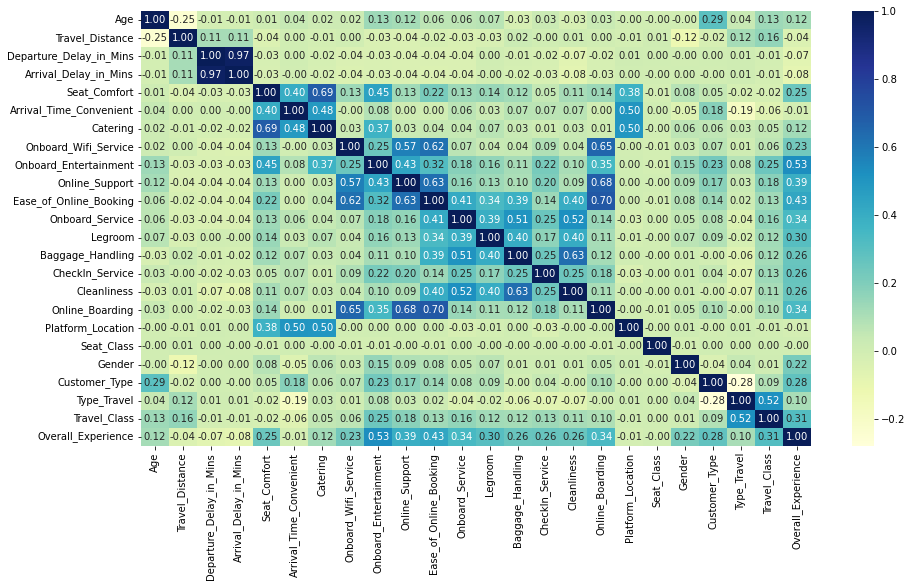

In [41]:
# Plotting the correlation between numerical variables
plt.figure(figsize=(15,8))
sns.heatmap(df6.corr(),annot=True, fmt='0.2f', cmap='YlGnBu')

In [42]:
## Checking for Multicollinearity between variables

In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df6

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
  
print(vif_data)

                    feature        VIF
0                       Age   1.225134
1           Travel_Distance   1.161547
2   Departure_Delay_in_Mins  14.876083
3     Arrival_Delay_in_Mins  14.889580
4              Seat_Comfort   2.326686
5   Arrival_Time_Convenient   1.693286
6                  Catering   2.456803
7      Onboard_Wifi_Service   2.130758
8     Onboard_Entertainment   1.995782
9            Online_Support   2.398730
10   Ease_of_Online_Booking   3.905696
11          Onboard_Service   1.701009
12                  Legroom   1.373616
13         Baggage_Handling   1.926187
14          CheckIn_Service   1.230133
15              Cleanliness   2.029680
16          Online_Boarding   2.847488
17        Platform_Location   1.626916
18               Seat_Class   1.000324
19                   Gender   1.074176
20            Customer_Type   1.457444
21              Type_Travel   1.758189
22             Travel_Class   1.726869
23       Overall_Experience   1.315483


# 8. Data Visualization on Processed Dataset

C:\Users\atiqah.razmi\AppData\Local\Temp\ipykernel_16092\2597563044.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_string['Overall_Experience'] = df['Overall_Experience']
C:\Users\atiqah.razmi\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


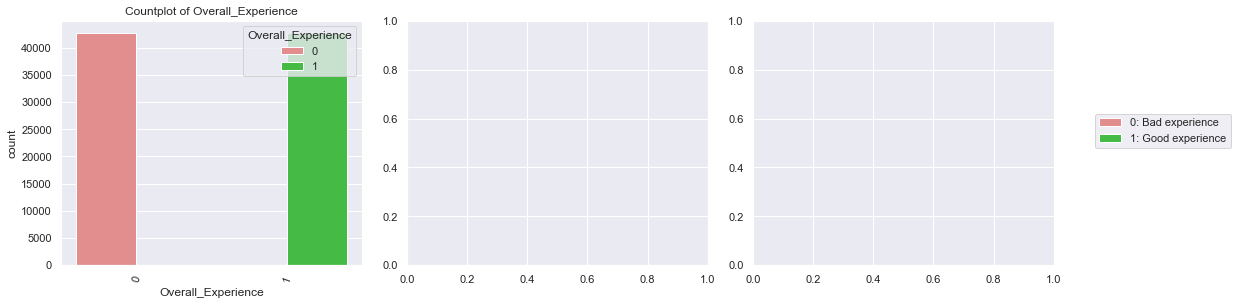

In [44]:
figure(15,5)
plot_cats(df6, 3)

C:\Users\atiqah.razmi\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\atiqah.razmi\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\atiqah.razmi\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `h

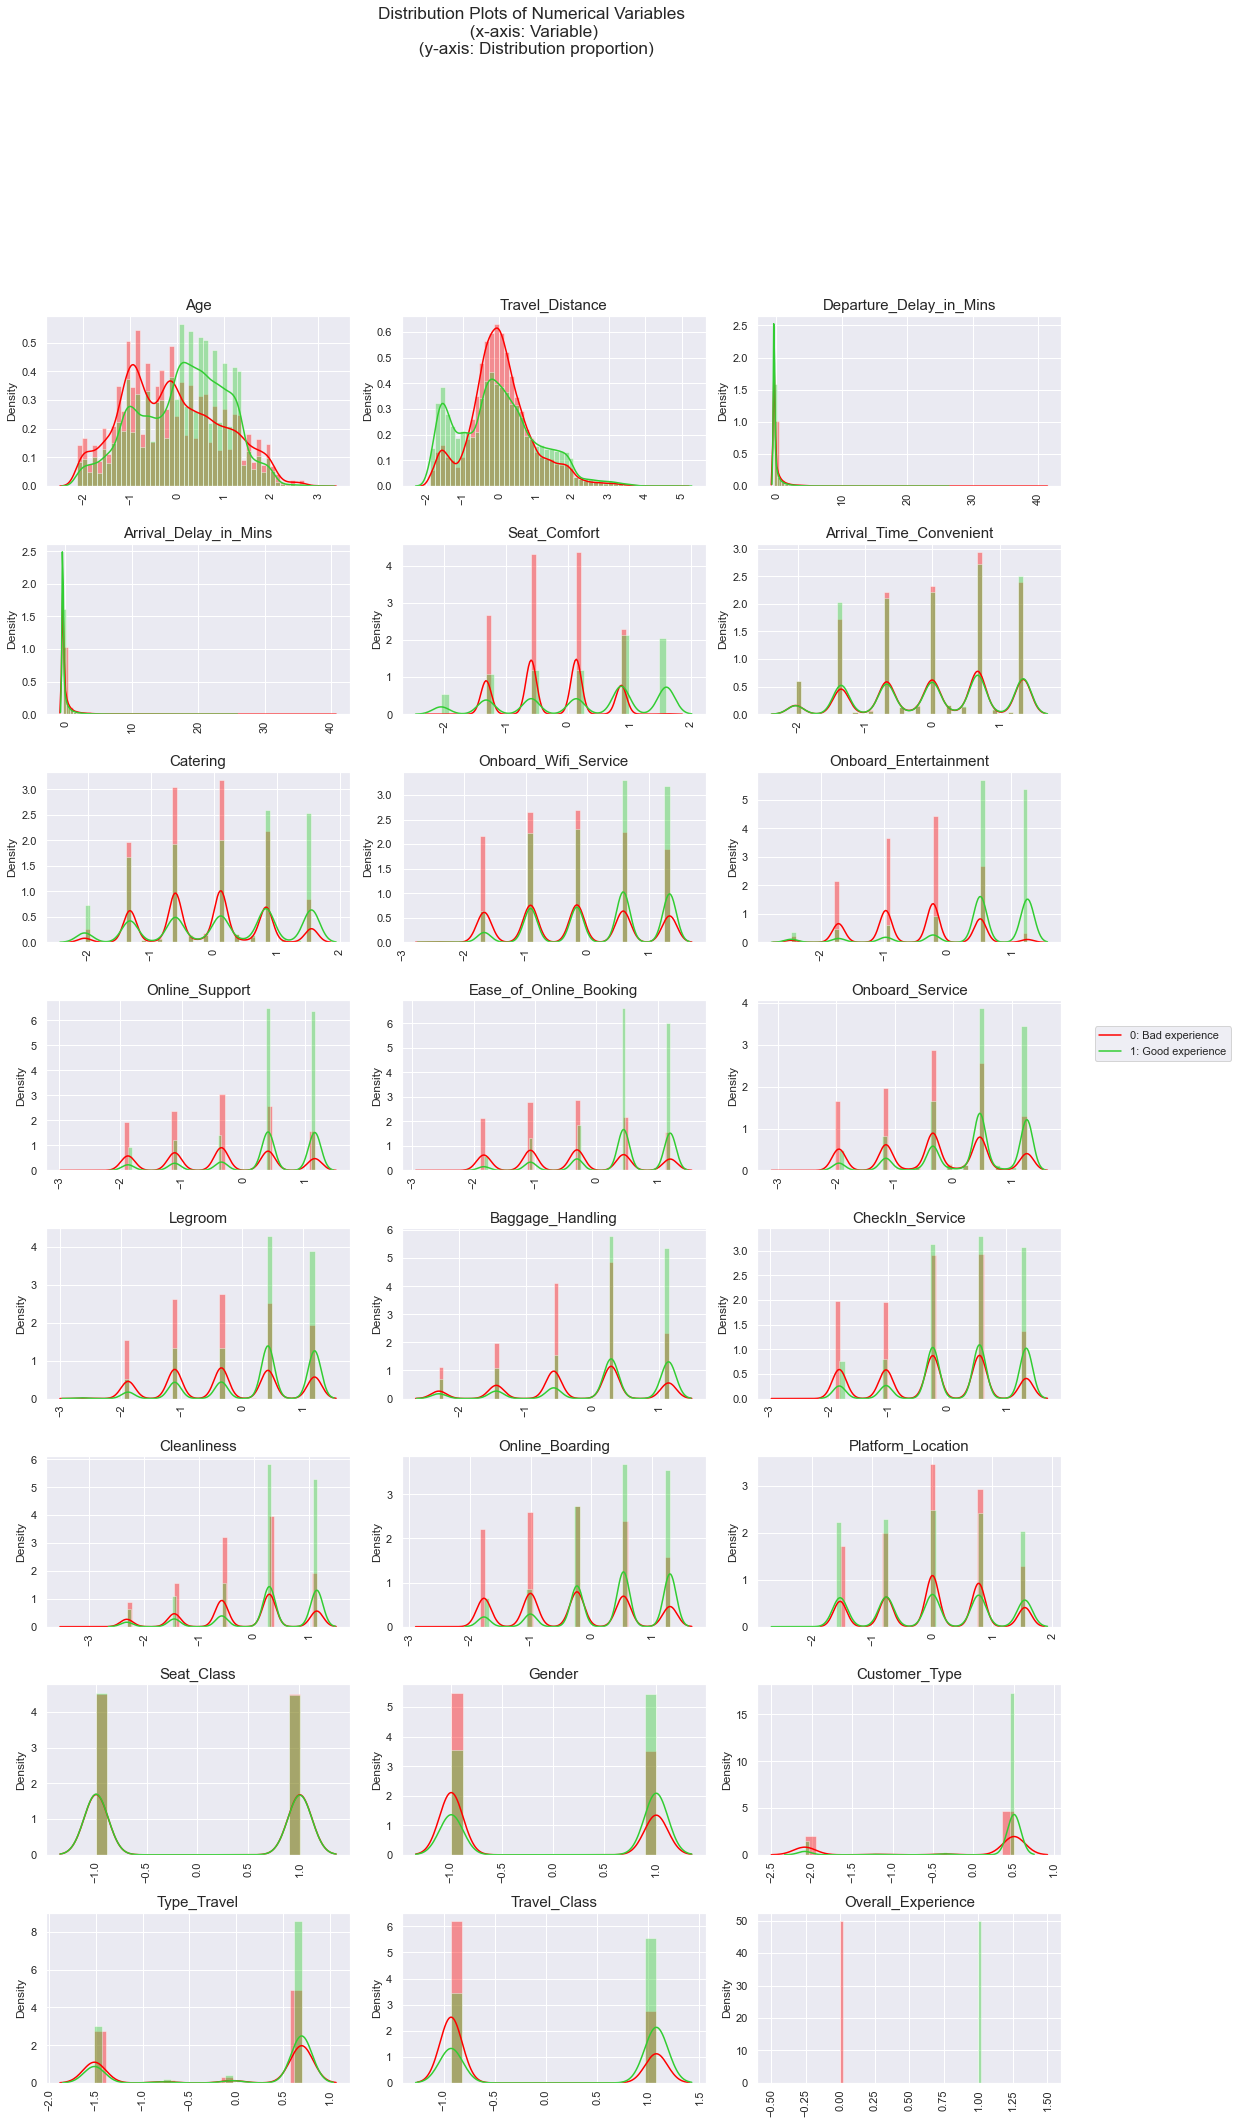

In [45]:
figure(15,30)
plot_nums(df6, 3)

In [46]:
df.head()

,ID,Overall_Experience,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,...,Cleanliness,Online_Boarding,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
0,98800001,0,Needs Improvement,Green Car,Excellent,Excellent,Very Convenient,Good,Needs Improvement,Acceptable,...,Needs Improvement,Poor,Female,Loyal Customer,52.0,NaN,Business,272,0.0,5.0
1,98800002,0,Poor,Ordinary,Excellent,Poor,Needs Improvement,Good,Poor,Good,...,Good,Good,Male,Loyal Customer,48.0,Personal Travel,Eco,2200,9.0,0.0
2,98800003,1,Needs Improvement,Green Car,Needs Improvement,Needs Improvement,Needs Improvement,Needs Improvement,Good,Excellent,...,Excellent,Excellent,Female,Loyal Customer,43.0,Business Travel,Business,1061,77.0,119.0
3,98800004,0,Acceptable,Ordinary,Needs Improvement,NaN,Needs Improvement,Acceptable,Needs Improvement,Acceptable,...,Acceptable,Acceptable,Female,Loyal Customer,44.0,Business Travel,Business,780,13.0,18.0
4,98800005,1,Acceptable,Ordinary,Acceptable,Acceptable,Manageable,Needs Improvement,Good,Excellent,...,Good,Good,Female,Loyal Customer,50.0,Business Travel,Business,1981,0.0,0.0


C:\Users\atiqah.razmi\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\atiqah.razmi\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-20.0, 200.0)

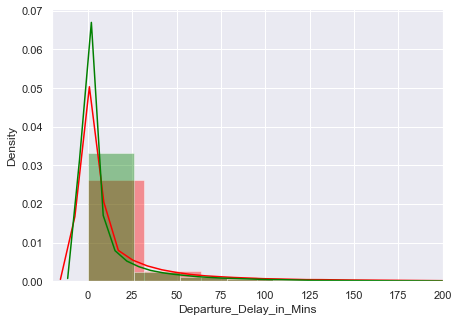

In [47]:
figure(7,5)

df0 = df[df.Overall_Experience == 0]
df1 = df[df.Overall_Experience == 1]

sns.distplot(df0['Departure_Delay_in_Mins'] , color='red')
sns.distplot(df1['Departure_Delay_in_Mins'] , color='green')
plt.xlim(-20,200)

In [48]:
import statistics

In [49]:
statistics.median(df['Departure_Delay_in_Mins'])

0.0

# 9. Split training set

In [50]:
# input: X = df6, y = df5.iloc[:,-1:]

In [51]:
X = df6.drop('Overall_Experience', axis=1)
y = df6['Overall_Experience']
print(X.shape)
print(y.shape)

(85572, 23)
(85572,)


In [56]:
# For splitting training / testing dataset
from sklearn.model_selection import train_test_split
def my_train_test_split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 100)
    return(X_train, X_test, y_train, y_test)

In [57]:
X_train, X_test, y_train, y_test = my_train_test_split(X, y)

In [58]:
# # Creating metric function 
# def metrics_score(actual, predicted):
#     print(classification_report(actual, predicted))

#     cm = confusion_matrix(actual, predicted)
#     plt.figure(figsize=(8,5))
    
#     sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Attrite', 'Attrite'], yticklabels=['Not Attrite', 'Attrite'])
#     plt.ylabel('Actual')
#     plt.xlabel('Predicted')
#     plt.show()

# 10. Modeling

## 10.1. Random Forest

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
df.Overall_Experience.value_counts(normalize=True)

1    0.546658
0    0.453342
Name: Overall_Experience, dtype: float64

In [61]:
# Activate Grid Search in a single evaluation run only
# # Grid Search
# rfc=RandomForestClassifier(random_state=75)
# param_grid = { 
#     'n_estimators': [100, 200, 500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth'   : [4,5,6,7,8],
#     'criterion'   : ['gini', 'entropy']
# }
# CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
# CV_rfc.fit(X, y)
# CV_rfc.best_params_

# {'criterion': 'gini',
#  'max_depth': 8,
#  'max_features': 'auto',
#  'n_estimators': 500}

In [62]:
# Fitting the Random Forest classifier on the training data
rf_estimator = RandomForestClassifier(class_weight = {0: 0.5, 1: 0.5}, 
                                      random_state = 75,  #75
                                      criterion='gini',
                                      n_estimators=100, #100,
                                      # max_depth=8,
                                      # max_features= 'auto'
                                      )
# rf_estimator.fit(X_train, y_train)

In [63]:
# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)

# evaluate the model on the dataset
n_scores = cross_val_score(rf_estimator, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

# y_pred_train = rf_estimator.predict(X_train)
# y_pred_test  = rf_estimator.predict(X_test)

# print ("Training Accuracy : ", round(accuracy_score(y_train, y_pred_train),5))
# print ("Testing Accuracy : " , round(accuracy_score(y_test, y_pred_test),5))

Mean Accuracy: 0.952 (0.001)


In [64]:
rf_estimator.fit(X, y)

RandomForestClassifier(class_weight={0: 0.5, 1: 0.5}, random_state=75)

## 10.2. Bagging Classifier

In [66]:
STOP

In [67]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [68]:
seed = 8
kfold = model_selection.KFold(n_splits = 3) # random_state = seed
  
# initialize the base classifier
base_cls = DecisionTreeClassifier()
  
# no. of base classifier
num_trees = 500
  
# bagging classifier
bagging_model = BaggingClassifier(base_estimator = base_cls,
                          n_estimators = num_trees,
                          random_state = seed)
  
results = model_selection.cross_val_score(bagging_model, X, y, cv = kfold)
print("accuracy :")
print(results.mean())

accuracy :
0.9106366568503717


In [69]:
bagging_model.fit(X, y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=500,
                  random_state=8)

In [70]:
# bagging_model

## 10.3. Logistic Regression Model

In [71]:
from sklearn.linear_model import LogisticRegression

In [72]:
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [73]:
y_pred_train = classifier.predict(X_train)
y_pred_test  = classifier.predict(X_test)

In [74]:
cm = confusion_matrix(y_test, y_pred_test)
print ("Confusion Matrix : \n", cm)

Confusion Matrix : 
 [[7140 1401]
 [1421 7153]]


In [75]:
print ("Training Accuracy : ", round(accuracy_score(y_train, y_pred_train),5))
print ("Testing Accuracy : " , round(accuracy_score(y_test, y_pred_test),5))

Training Accuracy :  0.833
Testing Accuracy :  0.83512


## 10.4. SVM (RBF)

In [77]:
STOP

In [78]:
from sklearn.svm import SVC

In [79]:
# Fitting SVM
# Linear Kernel
svm_rbf = SVC(kernel='rbf', probability=True) # Linear kernal or linear decision boundary

# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)

# evaluate the model on the dataset
n_scores = cross_val_score(svm_rbf, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

# y_pred_train = svm_rbf.predict(X_train)
# y_pred_test  = svm_rbf.predict(X_test)

# print ("Training Accuracy : ", round(accuracy_score(y_train, y_pred_train),5))
# print ("Testing Accuracy : " , round(accuracy_score(y_test, y_pred_test),5))

Mean Accuracy: 0.940 (0.002)


In [80]:
svm_rbf = svm_rbf.fit(X, y)

## 10.5. Gradient Boosting Tree

In [81]:
STOP

In [82]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

In [83]:
# define the model
gbt_model = GradientBoostingClassifier()

In [84]:
# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)

# evaluate the model on the dataset
n_scores = cross_val_score(gbt_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.920 (0.001)


In [85]:
gbt_model.fit(X, y)

GradientBoostingClassifier()

## 10.6. SVM (Linear)

In [86]:
STOP

In [87]:
from sklearn.svm import SVC

In [88]:
# Fitting SVM
# Linear Kernel
svm_linear = SVC(kernel='linear') # Linear kernal or linear decision boundary
svm_linear = svm_linear.fit(X = X_train, y = y_train)

In [89]:
y_pred_train = svm_linear.predict(X_train)
y_pred_test  = svm_linear.predict(X_test)

In [90]:
print ("Training Accuracy : ", round(accuracy_score(y_train, y_pred_train),5))
print ("Testing Accuracy : " , round(accuracy_score(y_test, y_pred_test),5))

Training Accuracy :  0.83651
Testing Accuracy :  0.83903


## 10.7. Ada Boost

In [91]:
STOP

In [92]:
from sklearn.ensemble import AdaBoostClassifier

In [93]:
# define the model
adaboost_model = AdaBoostClassifier()
adaboost_model.fit(X_train, y_train)

AdaBoostClassifier()

In [94]:
y_pred_train = adaboost_model.predict(X_train)
y_pred_test  = adaboost_model.predict(X_test)

In [95]:
print ("Training Accuracy : ", round(accuracy_score(y_train, y_pred_train),5))
print ("Testing Accuracy : " , round(accuracy_score(y_test, y_pred_test),5))

Training Accuracy :  0.89757
Testing Accuracy :  0.89746


# 11. Processing & Predicting on validation data

In [96]:
STOP

In [97]:
survey_data_test = pd.read_csv('Surveydata_test.csv')
travel_data_test = pd.read_csv('Traveldata_test.csv')

In [98]:
# 1) merge_data
df_test = merge_data(survey_data_test, travel_data_test)
df_test.shape

(35602, 24)

In [99]:
df_test.columns

Index(['ID', 'Seat_Comfort', 'Seat_Class', 'Arrival_Time_Convenient',
       'Catering', 'Platform_Location', 'Onboard_Wifi_Service',
       'Onboard_Entertainment', 'Online_Support', 'Ease_of_Online_Booking',
       'Onboard_Service', 'Legroom', 'Baggage_Handling', 'CheckIn_Service',
       'Cleanliness', 'Online_Boarding', 'Gender', 'Customer_Type', 'Age',
       'Type_Travel', 'Travel_Class', 'Travel_Distance',
       'Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins'],
      dtype='object')

In [100]:
# 2) encode multiple classes string data
df2_test = df_test.copy()
df_encode_test = encode_data(df2_test)

In [101]:
df_encode_test.head()

,Seat_Comfort,Arrival_Time_Convenient,Catering,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding,Platform_Location,Seat_Class,Gender,Customer_Type,Type_Travel,Travel_Class
0,3.0,3.0,3.0,2.0,5.0,4.0,5.0,5.0,5.0,5.0,4.0,5.0,1.0,3.0,0,1.0,NaN,1.0,1
1,0.0,4.0,1.0,3.0,1.0,3.0,3.0,5.0,3.0,4.0,3.0,5.0,3.0,3.0,1,1.0,0.0,1.0,1
2,5.0,5.0,5.0,5.0,5.0,5.0,2.0,2.0,2.0,2.0,4.0,2.0,5.0,5.0,1,0.0,1.0,1.0,1
3,3.0,5.0,3.0,1.0,3.0,5.0,1.0,3.0,2.0,5.0,5.0,5.0,1.0,5.0,0,1.0,1.0,0.0,0
4,5.0,0.0,5.0,5.0,5.0,5.0,5.0,NaN,3.0,5.0,5.0,5.0,5.0,2.0,1,0.0,0.0,1.0,1


In [102]:
# # one_hot_encode(df) / target_encode(df)
# # return(df_one_hot / df_target_encode)
# # variables for Target Encoding:
# cols_target = ['Seat_Class', 'Gender', 'Customer_Type', 'Type_Travel', 'Travel_Class']
# df_target_encode_test = df2_test[cols_target]
# df_target_encode_test.head()
# df_target_encode_test = target_encoder.transform(df_target_encode_test)
# df2_test[cols_target].head()

In [103]:
# 4) merged_encoded_data
df3_test = merged_encoded_data(df_encode_test, df2_test)
df3_test.tail(2)

,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Seat_Comfort,Arrival_Time_Convenient,Catering,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,...,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding,Platform_Location,Seat_Class,Gender,Customer_Type,Type_Travel,Travel_Class
35600,67.0,420,23.0,16.0,5.0,5.0,5.0,3.0,5.0,4.0,...,5.0,3.0,5.0,4.0,1.0,1,1.0,1.0,0.0,0
35601,20.0,1680,0.0,0.0,4.0,3.0,4.0,1.0,4.0,1.0,...,4.0,2.0,4.0,1.0,3.0,1,0.0,NaN,0.0,0


In [104]:
# 5) impute missing data by KNN imputer
df4_test = knn_impute(df3_test, imputer)
df4_test.head(2)

,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Seat_Comfort,Arrival_Time_Convenient,Catering,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,...,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding,Platform_Location,Seat_Class,Gender,Customer_Type,Type_Travel,Travel_Class
0,36.0,532.0,0.0,0.0,3.0,3.0,3.0,2.0,5.0,4.0,...,5.0,4.0,5.0,1.0,3.0,0.0,1.0,1.0,1.0,1.0
1,21.0,1425.0,9.0,28.0,0.0,4.0,1.0,3.0,1.0,3.0,...,4.0,3.0,5.0,3.0,3.0,1.0,1.0,0.0,1.0,1.0


In [105]:
# 6) standardscaler(df3) / minmaxscaler(df3)
df5_test = standardscaler(df4_test)
df5_test.head(2)

,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Seat_Comfort,Arrival_Time_Convenient,Catering,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,...,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding,Platform_Location,Seat_Class,Gender,Customer_Type,Type_Travel,Travel_Class
0,-0.227763,-1.420638,-0.392755,-0.398125,0.117279,0.007735,0.103740,-0.950408,1.200203,0.368224,...,1.130052,0.525017,1.1195,-1.810503,0.007959,-1.003320,0.984478,0.486127,0.682566,1.038491
1,-1.218793,-0.548819,-0.155179,0.327341,-2.035965,0.684930,-1.327049,-0.191068,-1.773793,-0.399821,...,0.264703,-0.268279,1.1195,-0.272529,0.007959,0.996691,0.984478,-2.166978,0.682566,1.038491


In [106]:
# 7) Drop column from VIF analysis
# No column is dropped based on VIF analysis
# df6_test = df6_test.drop(['Arrival_Delay_in_Mins'], axis=1)
df6_test = df5_test.copy()


In [107]:
df6_test.head()

,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Seat_Comfort,Arrival_Time_Convenient,Catering,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,...,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding,Platform_Location,Seat_Class,Gender,Customer_Type,Type_Travel,Travel_Class
0,-0.227763,-1.420638,-0.392755,-0.398125,0.117279,0.007735,0.103740,-0.950408,1.200203,0.368224,...,1.130052,0.525017,1.119500,-1.810503,0.007959,-1.003320,0.984478,0.486127,0.682566,1.038491
1,-1.218793,-0.548819,-0.155179,0.327341,-2.035965,0.684930,-1.327049,-0.191068,-1.773793,-0.399821,...,0.264703,-0.268279,1.119500,-0.272529,0.007959,0.996691,0.984478,-2.166978,0.682566,1.038491
2,1.357885,0.824810,-0.392755,-0.398125,1.552775,1.362125,1.534529,1.327611,1.200203,1.136270,...,-1.465996,0.525017,-1.487465,1.265445,1.545210,0.996691,-1.016325,0.486127,0.682566,1.038491
3,-0.690244,-0.620087,-0.392755,-0.398125,0.117279,1.362125,0.103740,-1.709747,-0.286795,1.136270,...,1.130052,1.318313,1.119500,-1.810503,1.545210,-1.003320,0.984478,0.486127,-1.550615,-0.962936
4,-1.416999,-0.368206,0.056000,-0.398125,1.552775,-2.023849,1.534529,1.327611,1.200203,1.136270,...,1.130052,1.318313,1.119500,1.265445,-0.760666,0.996691,-1.016325,-2.166978,0.682566,1.038491


In [109]:
# Checkpoint
# STOP

In [110]:
# 8) Define X & y
X_test = df6_test

In [111]:
# 8) Make prediction
y_pred = rf_estimator.predict(X_test)
# y_pred = svm_rbf.predict(X_test)
# y_pred = bagging_model.predict(X_test)

In [112]:
print(len(y_pred))
y_pred

35602


array([1, 1, 1, ..., 0, 1, 0], dtype=int64)

In [113]:
df_prediction = df_test[['ID']]
df_prediction['Overall_Experience'] = y_pred
df_prediction.head()

C:\Users\atiqah.razmi\AppData\Local\Temp\ipykernel_16092\102528131.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediction['Overall_Experience'] = y_pred


,ID,Overall_Experience
0,99900001,1
1,99900002,1
2,99900003,1
3,99900004,0
4,99900005,1


In [114]:
df_prediction.tail()

,ID,Overall_Experience
35597,99935598,0
35598,99935599,1
35599,99935600,0
35600,99935601,1
35601,99935602,0


In [115]:
df_prediction.to_csv('./df_prediction.csv')